# Imports

In [1]:
from tqdm import tqdm
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM, 
    AutoModelForMaskedLM, 
    AutoModelForCausalLM,
    GPTJForCausalLM)
from sklearn.linear_model import LogisticRegression

# Load the Model (GPT-J)

In [2]:
cache_dir = None
model_type = "decoder"
model = GPTJForCausalLM.from_pretrained("EleutherAI/gpt-j-6B", torch_dtype=torch.float16, low_cpu_mem_usage=True).to("cuda")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B", cache_dir=cache_dir)
model.cuda()

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): Embedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-27): 28 x GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): GPTJMLP(
          (fc_in): Linear(in_features=4096, out_features=16384, bias=True)
          (fc_out): Linear(in_features=16384, out_features=4096, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f)

# Load Dataset and Prompts

We want to use the imdb review dataset, and we will ask "is this review positive?". My current version of python does not support promptsource and I am too lazy to change it right now.

We will load three datasets:
1. Zero-shot dataset that provides the review and asks if it's positive
2. Helpful multishot dataset that prepends helpful examples to the review
3. Corrupt multishot dataset that prepends misleading examples to the review

First just explore the base dataset.

In [3]:
import tiktoken
import pandas as pd
enc = tiktoken.get_encoding("cl100k_base")

In [4]:
# test one example to intuit how model performance changes based on multishot prompt
data_test = load_dataset("amazon_polarity")["test"]
data_train = load_dataset("amazon_polarity")["train"]
test_df = pd.DataFrame(data_test)

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Dataset amazon_polarity downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Found cached dataset amazon_polarity (/home/ec2-user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
test_df.head()

,label,title,content
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [5]:
test_df.describe()

,label
count,400000.000000
mean,0.500000
std,0.500001
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


How many multishot prompts can we stuff into our prompt before we exceed 2048 tokens?

Create a multishot example out of each prompt (so like append 'yes' basically). Create new column that records the token length of each prompt. Then create histogram of length of each prompt.

In [7]:
# create a prompt column
test_df['prompt'] = test_df['content'].apply(lambda x: x + "\nIs this review positive?")
test_df.head()

,label,title,content,prompt
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,My lovely Pat has one of the GREAT voices of h...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,Despite the fact that I have only played a sma...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,I bought this charger in Jul 2003 and it worke...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,Check out Maha Energy's website. Their Powerex...
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Reviewed quite a bit of the combo players and ...


In [11]:
# create a helpful shot column
def append_yes_no(row):
    return row['prompt'] + (' yes' if row['label'] == 1 else ' no')
test_df['helpful_shot'] = test_df.apply(append_yes_no, axis=1)
test_df.head()

,label,title,content,prompt,helpful_shot
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,My lovely Pat has one of the GREAT voices of h...,My lovely Pat has one of the GREAT voices of h...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,Despite the fact that I have only played a sma...,Despite the fact that I have only played a sma...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,I bought this charger in Jul 2003 and it worke...,I bought this charger in Jul 2003 and it worke...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,Check out Maha Energy's website. Their Powerex...,Check out Maha Energy's website. Their Powerex...
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Reviewed quite a bit of the combo players and ...,Reviewed quite a bit of the combo players and ...


In [56]:
def append_corrupt_yes_no(row):
    return row['prompt'] + (' yes' if row['label'] == 0 else ' no')
test_df['corrupt_shot'] = test_df.apply(append_corrupt_yes_no, axis=1)
test_df.head()

,label,title,content,prompt,helpful_shot,tokens,num_tokens,corrupt_shot
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,My lovely Pat has one of the GREAT voices of h...,My lovely Pat has one of the GREAT voices of h...,"[5159, 17104, 7281, 706, 832, 315, 279, 62093,...",140,My lovely Pat has one of the GREAT voices of h...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,Despite the fact that I have only played a sma...,Despite the fact that I have only played a sma...,"[20397, 279, 2144, 430, 358, 617, 1193, 6476, ...",162,Despite the fact that I have only played a sma...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,I bought this charger in Jul 2003 and it worke...,I bought this charger in Jul 2003 and it worke...,"[40, 11021, 420, 45669, 304, 10263, 220, 1049,...",71,I bought this charger in Jul 2003 and it worke...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,Check out Maha Energy's website. Their Powerex...,Check out Maha Energy's website. Their Powerex...,"[4061, 704, 386, 13856, 12634, 596, 3997, 13, ...",51,Check out Maha Energy's website. Their Powerex...
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Reviewed quite a bit of the combo players and ...,Reviewed quite a bit of the combo players and ...,"[80772, 5115, 264, 2766, 315, 279, 23569, 4311...",85,Reviewed quite a bit of the combo players and ...


: 

In [18]:
test_df['tokens'] = test_df['helpful_shot'].apply(lambda x: enc.encode(x))
test_df['num_tokens'] = test_df['tokens'].apply(lambda x: len(x))
test_df.head()

,label,title,content,prompt,helpful_shot,tokens,num_tokens
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,My lovely Pat has one of the GREAT voices of h...,My lovely Pat has one of the GREAT voices of h...,"[5159, 17104, 7281, 706, 832, 315, 279, 62093,...",140
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,Despite the fact that I have only played a sma...,Despite the fact that I have only played a sma...,"[20397, 279, 2144, 430, 358, 617, 1193, 6476, ...",162
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,I bought this charger in Jul 2003 and it worke...,I bought this charger in Jul 2003 and it worke...,"[40, 11021, 420, 45669, 304, 10263, 220, 1049,...",71
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,Check out Maha Energy's website. Their Powerex...,Check out Maha Energy's website. Their Powerex...,"[4061, 704, 386, 13856, 12634, 596, 3997, 13, ...",51
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Reviewed quite a bit of the combo players and ...,Reviewed quite a bit of the combo players and ...,"[80772, 5115, 264, 2766, 315, 279, 23569, 4311...",85


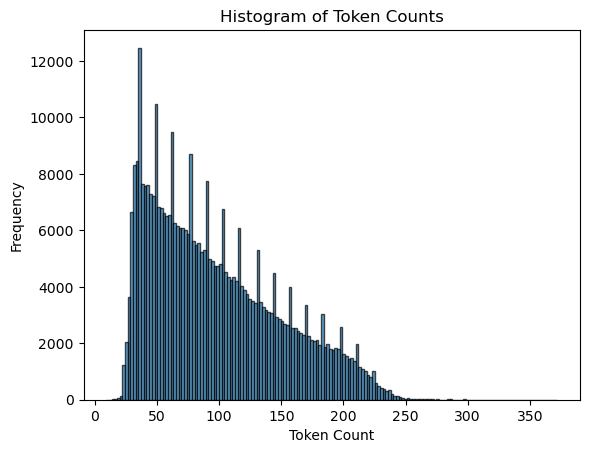

In [19]:
import matplotlib.pyplot as plt
# Plot the histogram of the 'tokens' column
plt.hist(test_df['num_tokens'], bins='auto', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Histogram of Token Counts')

# Show the plot
plt.show()

In [ ]:
# append multishot_true column and multishot_false column
def create_multi_true(row):
    multishot = test_df.iloc[100:110]['helpful_shot']
    multishot = "\n".join(multishot.values.tolist())
    

Look at how one example from the dataset changes depending on whether we include a helpful or misleading prompt. First we test the addition of the helpful prompt:

In [37]:
# with no multishot
p = test_df.iloc[3]['prompt']
input_ids = tokenizer(p, return_tensors="pt").input_ids.to("cuda")
gen_tokens = model.generate(
    input_ids,
    do_sample=True,
    temperature=0.9,
    max_length=100,
).to("cpu")
gen_text = tokenizer.batch_decode(gen_tokens)[0]
print(gen_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Check out Maha Energy's website. Their Powerex MH-C204F charger works in 100 minutes for rapid charge, with option for slower charge (better for batteries). And they have 2200 mAh batteries.
Is this review positive? I have a few concerns.

Maha is clearly the best charger for 100% charge in 100 minutes. I got the Maha charger, but it has a little problem. It is too expensive for me, so at present I am


In [55]:
# with helpful multishot
multishot = test_df.iloc[100:110]['helpful_shot']
multishot = "\n".join(multishot.values.tolist())

print("--------------The prompt we want to answer: -------------")
print(p)

p_multi = multishot + "\n" + p
print("--------------Our MultiShot prompt: -------------------")
print(p_multi)

input_ids = tokenizer(p_multi, return_tensors="pt").input_ids.to("cuda")
gen_tokens = model.generate(
    input_ids,
    do_sample=True,
    temperature=0.2,
    max_length=100,
).to("cpu")

gen_text = tokenizer.batch_decode(gen_tokens)[0]
print("------------------The model response --------------------")
print(gen_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 767, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


--------------The prompt we want to answer: -------------
Check out Maha Energy's website. Their Powerex MH-C204F charger works in 100 minutes for rapid charge, with option for slower charge (better for batteries). And they have 2200 mAh batteries.
Is this review positive?
--------------Our MultiShot prompt: -------------------
Ditto to other complaints - won't separate easily- either by unscrewing or prizing. Cheap, flimsy, leaks water also because no gasket. I'm looking for something else and hoping reviewers will give honest good advice . . . this almost identical to product by Munchkin
Is this review positive? no
We tried the Baby warming dish. We found that for our 1 year old it was pretty small, and didn't really hold enough water to keep her warm.I think it would work ok for an infant, although I think a blanket would work just as well.Recommendation:Buy********************HoldSell
Is this review positive? yes
As good as this book may be, the print quality is so bad that I canno

# Extract Hidden States of GPT-J 

  For each dataset above
     For each prompt
        For each layer of the model
            save the model activation from appending the truthful example
            save the model activation from appending the untruthful example

# Analyze the Hidden States of GPT-J for their Predictive Capabilities

If we find the layer that has the most predictive hidden states, we can then visualize the attention heads in that layer with TransformerLens.